## Motivation

Building attributes such as building height, type, and construction year are not available for all buildings in EUBUCCO. However, for many prospective use cases of the dataset, such as energy modeling, the building attributes are of high importance. This notebook shows how the available building footprints can be used to estimate missing building attributes with supervised machine learning.

In [1]:
# -.-|m { input: false }

# standard libs
import os
import sys
import logging
import gc

# project lib
PROJECT_SRC_PATH = os.path.join( '/workspace/workspace/ufo-prediction', 'src-UFO-CNN')
sys.path.append(PROJECT_SRC_PATH)

import visualizations
from prediction_age import AgePredictor, AgeClassifier, AgePredictorComparison
import preprocessing as pp
import dataset
import utils

# external libs
import numpy as np
import pandas as pd
import geopandas as gpd
from xgboost import XGBRegressor, XGBClassifier
import xgboost as xgb

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-8l4d6lsc because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# -.-|m { input: false }

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

## Data

Demo sample of ~20k buildings for Spain, ~50k for France, and 170k for the Netherlands. All 117 urban form features, lat lon, as well as some auxiliary attributes like city name, neighborhood, building type, etc. are included.

The demo samples are stored using Git Large File Storage (LFS). To download them explicitly use:

In [3]:
path_data_RCA = os.path.join(dataset.DATA_DIR, 'ufo-CNN_ALL.csv')
df = pd.read_csv(path_data_RCA, encoding='latin1')

In [4]:
print(df.columns.to_list())

['id', 'Class_0', 'Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6', 'Predicted Class', 'source_file', 'dist_to_closest_int', 'av_footprint_area_within_buffer_100', 'street_betweeness_global_max_within_buffer_500', 'av_elongation_within_buffer_500', 'geometry', 'std_building_footprint_city', 'block', 'blocks_2_to_4', 'street_closeness_500_av_within_buffer_500', 'street_width_std_within_buffer_100', 'av_footprint_area_within_buffer_500', 'street_length_total_within_buffer_500', 'BlockConvexity', 'buildings_within_buffer_500', 'StdBlockFootprintArea', 'street_closeness_global_closest_street', 'std_block_footprint_area_within_buffer_100', 'street_based_block_std_orientation_inter_buffer_100', 'street_length_std_within_buffer_100', 'AvBlockFootprintArea', 'std_block_length_within_buffer_100', 'street_betweeness_global_av_within_buffer_500', 'street_based_block_std_area_inter_buffer_500', 'street_length_closest_street', 'Elongation', 'age', 'BlockLength', 'street_closeness_50

In [5]:
df['Predicted Class']

0       6
1       4
2       4
3       1
4       4
       ..
2116    6
2117    4
2118    4
2119    3
2120    0
Name: Predicted Class, Length: 2121, dtype: int64

In [6]:
df['Predicted Class'].dtype

dtype('int64')

In [7]:
df = df.rename(columns={'age': 'age_right'})

In [8]:
print(len(df))

2121


## Prediction

In [9]:
xgb_model_params = {'tree_method': 'hist'}
xgb_hyperparams = {
    'max_depth': 5,
    'learning_rate': 0.1,
    'n_estimators': 500,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

### Regression

Here we deliberately predict "age_right" the age variable from EUBUCCO, given that for NLD it is 100% available and therefore has higher coverage than YearBlt from RCA. YearBlt and age_right have a correlation of 0.6 To make results more comparable, in the RCA only version, I revert to using YearBlt instead of YearBlt_new2, given that YearBlt_new2 has a correlation of only 0.22 with age_right from EUBUCCO.

2024-04-15 20:13:48,329 | INFO : Dataset length: 2121
2024-04-15 20:13:48,334 | INFO : Dataset allocated memory: 2 MB
2024-04-15 20:13:48,337 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-bc26cf96.abort.
2024-04-15 20:13:48,338 | INFO : Dataset standard deviation: 32.013550299701095
2024-04-15 20:13:48,338 | INFO : Dataset mean age: 1961.992927864215
2024-04-15 20:13:48,339 | INFO : Training dataset length: 1696
2024-04-15 20:13:48,339 | INFO : Test dataset length: 425
2024-04-15 20:13:48,348 | INFO : Test dataset standard deviation after preprocessing: 30.089123437792576
2024-04-15 20:13:48,349 | INFO : Test dataset mean age after preprocessing: 1961.2912621359224
2024-04-15 20:13:48,349 | INFO : Training dataset length after preprocessing: 1625
2024-04-15 20:13:48,350 | INFO : Test dataset length after preprocessing: 412
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, u

MAE: 20.63 y
RMSE: 26.10 y
R2: 0.2456
Energy need for heating in kWh/(m²a) R2: nan
Energy need for heating in kWh/(m²a) MAPE: nan


FixedFormatter should only be used together with FixedLocator


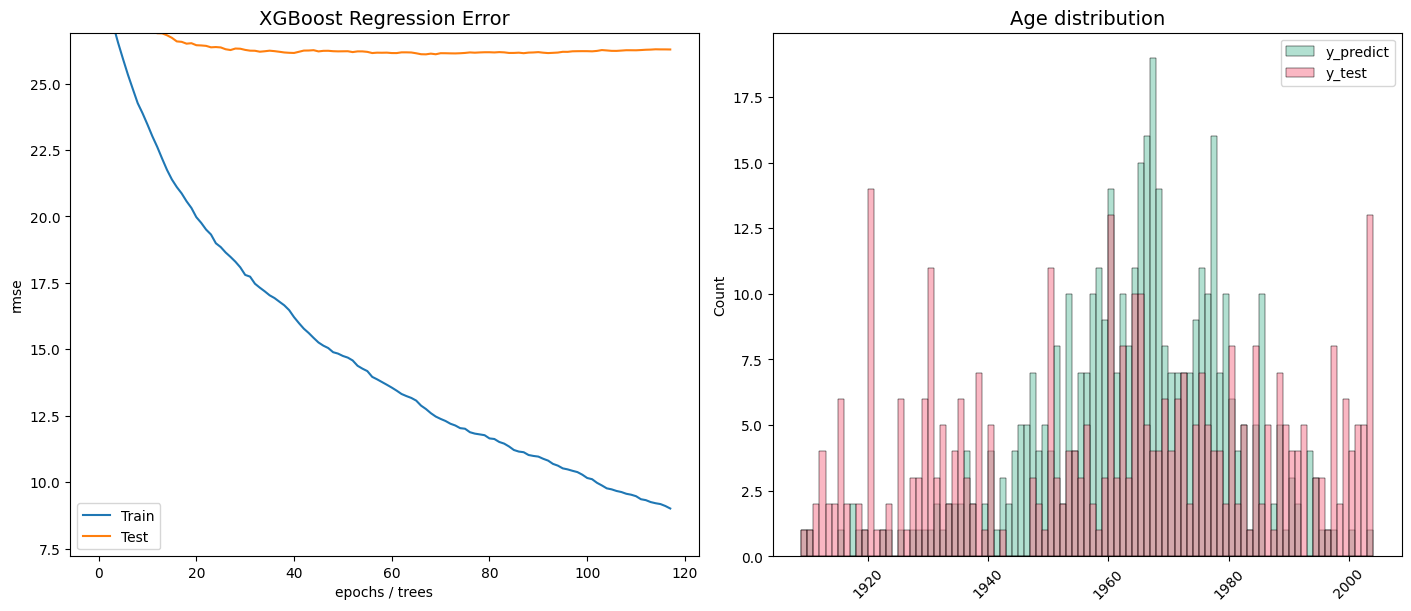

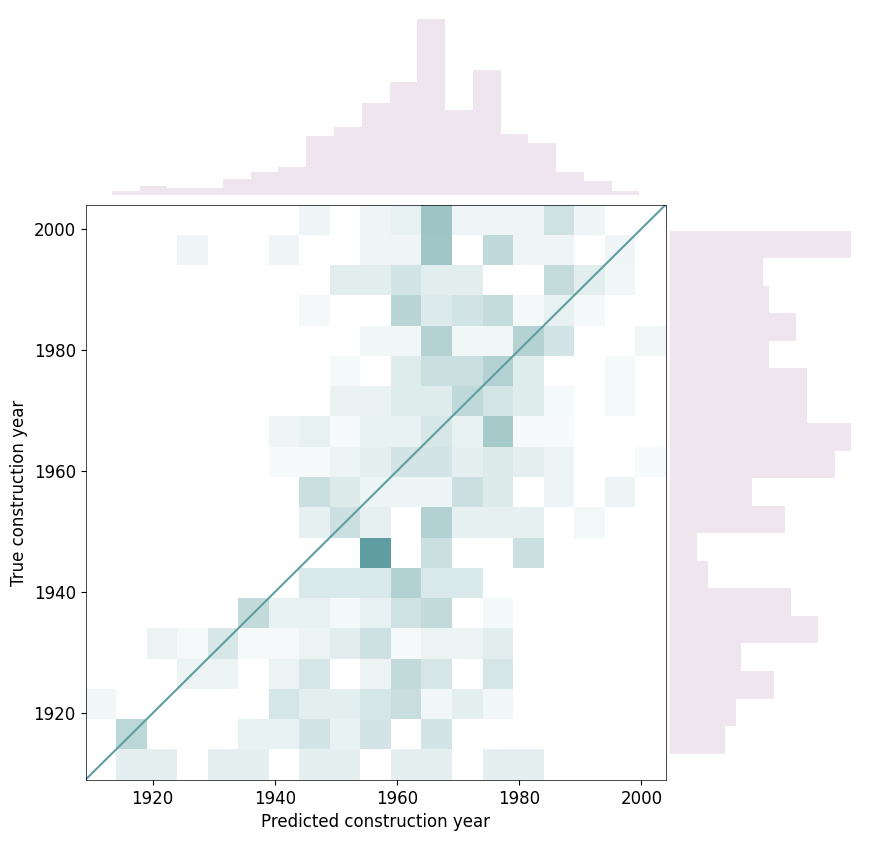

In [10]:
predictor = AgePredictor(
    model=XGBRegressor(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    early_stopping=True,
    hyperparameters=xgb_hyperparams,
    preprocessing_stages=[pp.remove_outliers]
)

predictor.evaluate()


### Classification

2024-04-15 20:13:53,487 | INFO : Generated bins: [1900, 1945, 1970, 1980, 1990, 2000, 2010, 2051]
2024-04-15 20:13:53,488 | INFO : Generated bins with the following labels: ['1900-1944', '1945-1969', '1970-1979', '1980-1989', '1990-1999', '2000-2009', '2010-2050']
2024-04-15 20:13:53,491 | INFO : Dataset length: 2121
2024-04-15 20:13:53,496 | INFO : Dataset allocated memory: 2 MB
2024-04-15 20:13:53,499 | INFO : No abort signal received. Continuing... To abort please create workspace/ufo-prediction/metadata/local-f628ae1e.abort.
2024-04-15 20:13:53,499 | INFO : Training dataset length: 1696
2024-04-15 20:13:53,500 | INFO : Test dataset length: 425
2024-04-15 20:13:53,501 | INFO : Test cities: ['VÃ©lez-MÃ¡laga' 'Sluis' 'Salamanca' 'Sabadell' 'MÃ¡laga (AndalucÃ\xada)'
 'Veere' 'Medio Cudeyo' 'Venlo' 'Reimerswaal' 'Ciudad Rodrigo'
 'Pedrezuela' 'Saint-Symphorien' 'GerbÃ©viller' 'Constantina' 'Madrid'
 'Maastricht' 'Ã\x89trÃ©chy' 'Hengelo (Overijssel)'
 'Saint-Symphorien-sur-Coise' 'Sint-M

Classification report:
               precision    recall  f1-score  support
1900-1944      0.643357  0.724409  0.681481      127
1945-1969      0.446281  0.490909  0.467532      110
1970-1979      0.367347  0.391304  0.378947       46
1980-1989      0.320000  0.181818  0.231884       44
1990-1999      0.281250  0.250000  0.264706       36
2000-2009      0.166667  0.157895  0.162162       38
2010-2050      0.000000  0.000000  0.000000       11
accuracy       0.453883  0.453883  0.453883        0
macro avg      0.317843  0.313762  0.312388      412
weighted avg   0.432606  0.453883  0.440055      412
Cohen’s kappa: 0.2995
Matthews correlation coefficient (MCC): 0.3005


FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


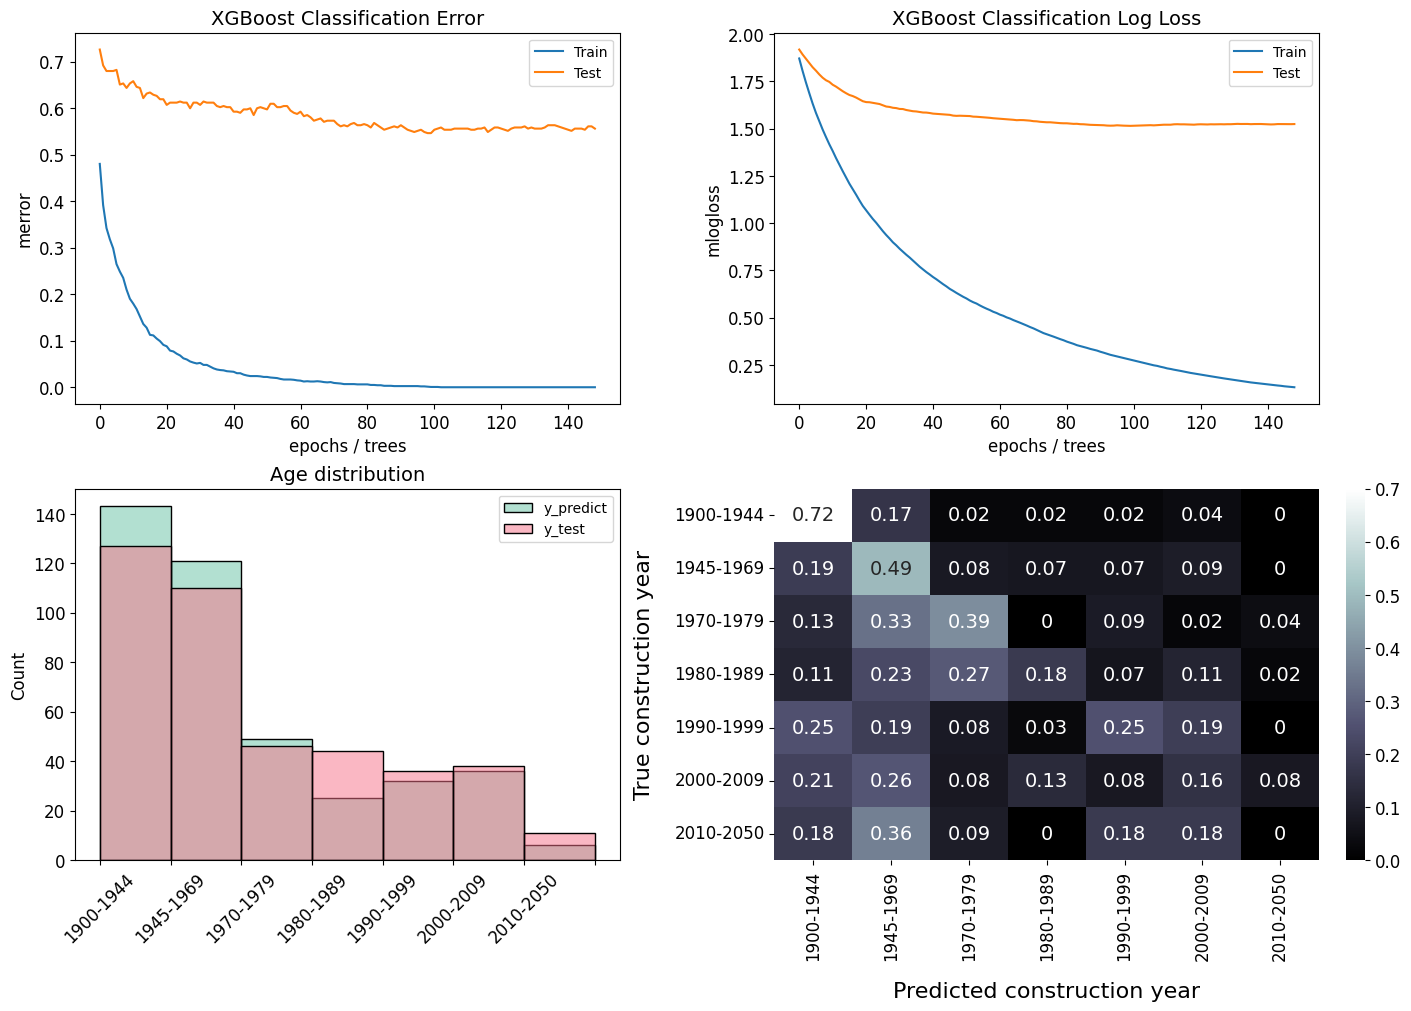

In [11]:
tabula_nl_bins = [1900, 1965, 1975, 1992, 2006, 2015, 2022]
equally_sized_bins = [1900, 1945, 1970, 1980, 1990, 2000, 2010, 2051]

classifier = AgeClassifier(
    model=XGBClassifier(**xgb_model_params),
    df=df,
    test_training_split=pp.split_80_20,
    # cross_validation_split=pp.cross_validation,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    mitigate_class_imbalance=True,
    # bin_config=equally_sized_bins,
    bins=equally_sized_bins,
)
classifier.evaluate(vmax=0.7)

### Country and generalization comparison

The `AgePredictorComparison` faciliates comparisons between differently configured training runs, for example to compare the prediction performance between countries, cross-validation strategies, oversampling strategies or any other preprocessing steps.

In [ ]:
comparison_config = {
    'Spain': {'df': path_data_ESP},
    'France': {'df': path_data_FRA},
    'Netherlands': {'df': path_data_NLD},
}

grid_comparison_config = {
    'random-cv': {'cross_validation_split': pp.cross_validation},
    'neighborhood-cv': {'cross_validation_split': pp.neighborhood_cross_validation},
    'city-cv': {'cross_validation_split': pp.city_cross_validation},
}

comparison = AgePredictorComparison(
    exp_name='demo',
    model=XGBRegressor(**xgb_model_params),
    df=None,
    frac=0.5,
    cross_validation_split=None,
    preprocessing_stages=[pp.remove_outliers],
    hyperparameters=xgb_hyperparams,
    compare_feature_importance=False,
    compare_classification_error=False,
    include_baseline=False,
    save_results=False,
    garbage_collect_after_training=True,
    comparison_config=comparison_config,
    grid_comparison_config=grid_comparison_config,
)

results = comparison.evaluate()

2022-10-21 16:42:52,510 | INFO : Starting experiment Spain_random-cv...
2022-10-21 16:42:53,720 | INFO : Dataset length: 974
2022-10-21 16:42:53,726 | INFO : Dataset allocated memory: 1 MB
2022-10-21 16:42:53,731 | INFO : No abort signal received. Continuing... To abort please create /p/projects/eubucco/data/3-ml-inputs/local-1eb3cae2.abort.
2022-10-21 16:42:53,731 | INFO : Dataset standard deviation: 45.78138305502198
2022-10-21 16:42:53,732 | INFO : Dataset mean age: 1950.3613963039015
2022-10-21 16:42:53,733 | INFO : Training dataset length: 779
2022-10-21 16:42:53,733 | INFO : Test dataset length: 195
2022-10-21 16:42:53,748 | INFO : Test dataset standard deviation after preprocessing: 34.49407581359104
2022-10-21 16:42:53,749 | INFO : Test dataset mean age after preprocessing: 1958.8352272727273
2022-10-21 16:42:53,749 | INFO : Training dataset length after preprocessing: 710
2022-10-21 16:42:53,749 | INFO : Test dataset length after preprocessing: 176
`early_stopping_rounds` in `

In [ ]:
results

,name,R2,R2_std,MAE,MAE_std,RMSE,RMSE_std,within_5_years,within_10_years,within_20_years,R2_seed_0
8,Netherlands_city-cv,0.135401,0.0,18.030643,0.0,23.598668,0.0,0.221385,0.392977,0.638903,0.135401
7,France_city-cv,0.187767,0.0,18.645831,0.0,23.772030,0.0,0.176875,0.345911,0.615315,0.187767
6,Spain_city-cv,0.197072,0.0,23.840955,0.0,29.563272,0.0,0.126411,0.247178,0.494357,0.197072
3,Spain_neighborhood-cv,0.198503,0.0,23.779078,0.0,29.536916,0.0,0.129797,0.247178,0.506772,0.198503
5,Netherlands_neighborhood-cv,0.304538,0.0,15.884060,0.0,21.164937,0.0,0.241489,0.444702,0.699700,0.304538
4,France_neighborhood-cv,0.330228,0.0,16.306574,0.0,21.586864,0.0,0.211348,0.408337,0.705209,0.330228
0,Spain_random-cv,0.363164,0.0,20.108252,0.0,26.328608,0.0,0.180587,0.355530,0.592551,0.363164
1,France_random-cv,0.511105,0.0,12.372172,0.0,18.443089,0.0,0.369564,0.593466,0.806340,0.511105
2,Netherlands_random-cv,0.575725,0.0,10.203823,0.0,16.531180,0.0,0.525335,0.695626,0.827052,0.575725


In [ ]:
del comparison, predictor, classifier, results, df, df_filtered
gc.collect()